In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from geopy import distance
import pickle
from utils_dump_load import load_from_pickle, dump_to_pickle

<h1> EDA

<h2> Loading data

In [74]:
filepath_test = "data/Test.csv"
df_test = pd.read_csv(filepath_test, index_col="Order No")
df_test.shape

(7068, 24)

In [75]:
filepath_train = "data/Train.csv"
df_train = pd.read_csv(filepath_train, index_col="Order No")
df_train.shape

(21201, 28)

In [76]:
df_train.head()

,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Confirmation - Time,...,Arrival at Destination - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival
Order No,,,,,,,,,,,,,,,,,,,,,
Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,9:40:10 AM,...,10:39:55 AM,4,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745
Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,11:23:21 AM,...,12:17:22 PM,16,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993
Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,12:42:44 PM,...,1:00:38 PM,3,NaN,NaN,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455
Order_No_9336,User_Id_1402,Bike,3,Business,15,5,9:25:34 AM,15,5,9:26:05 AM,...,10:05:27 AM,9,19.2,NaN,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,1341
Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,9:55:18 AM,13,1,9:56:18 AM,...,10:25:37 AM,9,15.4,NaN,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,1214


In [77]:
filepath_riders = "data/Riders.csv"
df_riders = pd.read_csv(filepath_riders, index_col="Rider Id")
df_riders.shape

(960, 4)

In [78]:
df_riders.head()

,No_Of_Orders,Age,Average_Rating,No_of_Ratings
Rider Id,,,,
Rider_Id_396,2946,2298,14.0,1159
Rider_Id_479,360,951,13.5,176
Rider_Id_648,1746,821,14.3,466
Rider_Id_753,314,980,12.5,75
Rider_Id_335,536,1113,13.7,156


<h2> Merge data

In [79]:
df_train = df_train.merge(df_riders, left_on='Rider Id', right_on='Rider Id', right_index=True)
df_test = df_test.merge(df_riders, left_on='Rider Id', right_on='Rider Id', right_index=True)

<h2> Compute geopy distance

In [80]:
def compute_distance(row):
    src = (row["Pickup Lat"],row["Pickup Long"])
    dest= (row["Destination Lat"],row["Destination Long"])
    return distance.distance(src,dest).km

In [81]:
df_train["geopy_distance"] = df_train.apply(compute_distance,axis=1)
df_test["geopy_distance"] = df_test.apply(compute_distance,axis=1)

<h2> Compute speed / geospeed

In [82]:
speed_threshold = 10000

In [83]:
df_train["speed"] = (df_train["Distance (KM)"] / df_train["Time from Pickup to Arrival"])*3600
df_train["geospeed"] = (df_train["geopy_distance"] / df_train["Time from Pickup to Arrival"])*3600

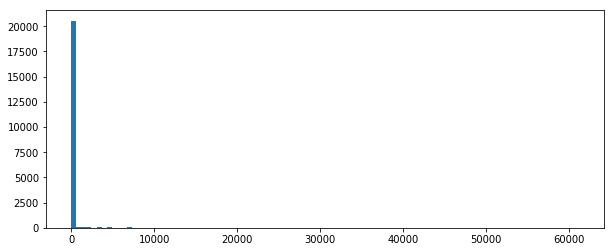

In [84]:
plt.figure(figsize=(10,4))
plt.hist(df_train["speed"], bins=100)
plt.show()

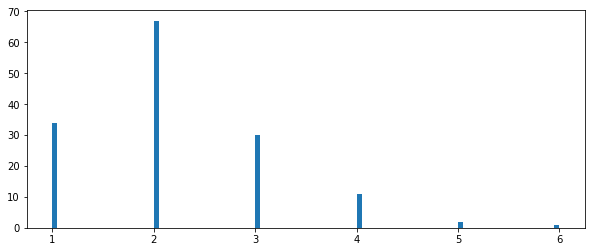

In [85]:
plt.figure(figsize=(10,4))
plt.hist(df_train[df_train["speed"]>speed_threshold]["Time from Pickup to Arrival"], bins=100)
plt.show()

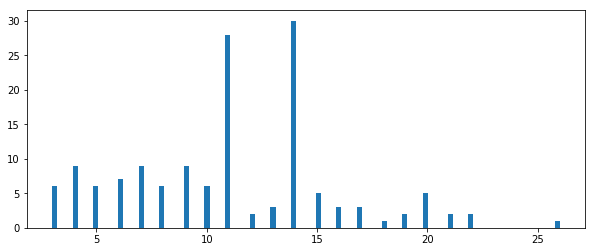

In [86]:
plt.figure(figsize=(10,4))
plt.hist(df_train[df_train["speed"]>speed_threshold]["Distance (KM)"], bins=100)
plt.show()

In [87]:
mean_speed = df_train.groupby("Rider Id")["speed"].mean()
mean_geospeed = df_train.groupby("Rider Id")["geospeed"].mean()

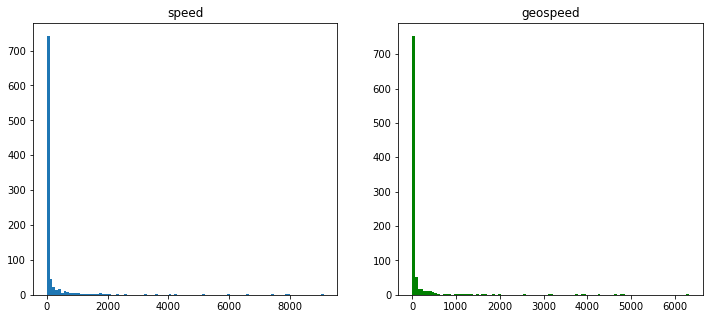

In [88]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.hist(mean_speed[mean_speed<speed_threshold], bins=100)
plt.title("speed")

plt.subplot(1, 2, 2)
plt.hist(mean_geospeed[mean_geospeed<speed_threshold], bins=100, color="g")
plt.title("geospeed")

plt.show()

In [89]:
mean_riders_speed = df_train["speed"].mean()
mean_riders_geospeed = df_train["geospeed"].mean()
mean_riders_speed, mean_riders_geospeed

(249.30537853208438, 156.5807340761476)

In [90]:
def get_speed(r_id):
    try:
        return mean_speed[r_id]
    except:
        return "NaN"

In [91]:
def get_geospeed(r_id):
    try:
        return mean_geospeed[r_id]
    except:
        return "NaN"

In [92]:
df_riders = df_riders.reset_index()

In [93]:
df_riders["speed"] = df_riders["Rider Id"].apply(lambda x: get_speed(x))
df_riders["geospeed"] = df_riders["Rider Id"].apply(lambda x: get_geospeed(x))

In [94]:
riders_columns = ['No_Of_Orders', 'Age', 'Average_Rating','No_of_Ratings', 'speed', 'geospeed']
data = df_riders[riders_columns]
df_riders = pd.DataFrame(data.values, index=df_riders["Rider Id"], columns=riders_columns)
df_riders.head()

,No_Of_Orders,Age,Average_Rating,No_of_Ratings,speed,geospeed
Rider Id,,,,,,
Rider_Id_396,2946,2298,14,1159,25.8673,8.86556
Rider_Id_479,360,951,13.5,176,20.6516,12.5004
Rider_Id_648,1746,821,14.3,466,27.9318,19.8829
Rider_Id_753,314,980,12.5,75,20.3334,13.712
Rider_Id_335,536,1113,13.7,156,NaN,NaN


<h1> ML: Speed regression

<h2> Data preparation

In [95]:
df_riders_test = df_riders[df_riders["speed"] == "NaN"]
y__speed_test = df_riders_test["speed"]
y__geospeed_test = df_riders_test["geospeed"]
X__test = df_riders_test.drop(["speed", "geospeed"], axis=1)
df_riders_test.shape

(36, 6)

In [96]:
df_riders_train = df_riders[df_riders["speed"] != "NaN"]
y_speed = df_riders_train["speed"]
y_geospeed = df_riders_train["geospeed"]
X = df_riders_train.drop(["speed", "geospeed"], axis=1)
df_riders_train.shape

(924, 6)

In [100]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y_speed, random_state=0, test_size=0.2)

In [101]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [102]:
mean_squared_error(y_pred, y_test)

836759.3083792542

<h1> Filling df_riders with speed prediction

In [108]:
from sklearn.linear_model import LinearRegression
model_s = LinearRegression()
model_s.fit(X, y_speed)
y__speed_pred = model_s.predict(X__test)

In [109]:
model_g = LinearRegression()
model_g.fit(X, y_geospeed)
y__geospeed_pred = model_g.predict(X__test)

In [118]:
df_speed_pred = pd.DataFrame(data=y__speed_pred , index = X__test.index, columns=["speed"])
df_speed_pred.head()

,speed
Rider Id,
Rider_Id_335,61.301760
Rider_Id_757,462.733479
Rider_Id_437,-181.532449
Rider_Id_153,46.481889
Rider_Id_374,488.863389


In [119]:
df_geospeed_pred = pd.DataFrame(data=y__geospeed_pred , index = X__test.index, columns=["geospeed"])
df_geospeed_pred.head()

,geospeed
Rider Id,
Rider_Id_335,39.044116
Rider_Id_757,294.327071
Rider_Id_437,-118.361945
Rider_Id_153,30.520078
Rider_Id_374,308.727129


In [120]:
y__pred

array([  61.30175964,  462.73347935, -181.53244944,   46.48188898,
        488.86338918, -238.40159735, -124.5007029 ,  -15.91636872,
         61.0563267 , 1422.66899636, -146.22823615,  703.07170285,
        253.64257352, -115.78216229,   42.13742649,  -70.67453708,
        262.79850504,   -3.72129637,   30.78010762,  247.16606177,
        -15.33075474,  -34.06864926, -185.4543736 ,  112.07678158,
        272.18611586,   83.75850357,  113.70470814,  109.46282333,
        439.44213328,  377.31203962,  432.76541383,   18.60609602,
        131.9810178 ,  295.90806586,  163.80252983,  178.34129838])

In [30]:
y__pred_sort = sorted(y__pred)

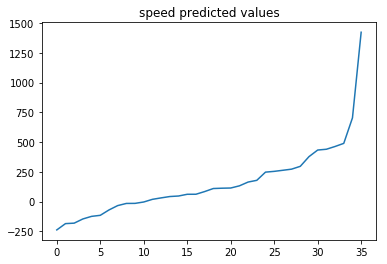

In [31]:
plt.figure()
plt.plot(np.arange(len(y__pred)), y__pred_sort)
plt.title("speed predicted values")
plt.show()

In [121]:
df__pred = pd.concat([X__test, df_speed_pred, df_geospeed_pred], axis=1)
print(df__pred.shape)
df__pred.head()

(36, 6)


,No_Of_Orders,Age,Average_Rating,No_of_Ratings,speed,geospeed
Rider Id,,,,,,
Rider_Id_335,536,1113,13.7,156,61.301760,39.044116
Rider_Id_757,2101,1066,12.3,229,462.733479,294.327071
Rider_Id_437,2966,2053,14,1147,-181.532449,-118.361945
Rider_Id_153,233,982,13.9,85,46.481889,30.520078
Rider_Id_374,1985,1191,12.3,143,488.863389,308.727129


In [122]:
print(df_riders_train.shape)
df_riders_train.head()

(924, 6)


,No_Of_Orders,Age,Average_Rating,No_of_Ratings,speed,geospeed
Rider Id,,,,,,
Rider_Id_396,2946,2298,14,1159,25.8673,8.86556
Rider_Id_479,360,951,13.5,176,20.6516,12.5004
Rider_Id_648,1746,821,14.3,466,27.9318,19.8829
Rider_Id_753,314,980,12.5,75,20.3334,13.712
Rider_Id_720,2608,1798,13.2,504,41.3711,28.4343


In [123]:
df__riders = pd.concat([df__pred, df_riders_train], axis=0)
print(df__riders.shape)
df__riders.head()

(960, 6)


,No_Of_Orders,Age,Average_Rating,No_of_Ratings,speed,geospeed
Rider Id,,,,,,
Rider_Id_335,536,1113,13.7,156,61.3018,39.0441
Rider_Id_757,2101,1066,12.3,229,462.733,294.327
Rider_Id_437,2966,2053,14,1147,-181.532,-118.362
Rider_Id_153,233,982,13.9,85,46.4819,30.5201
Rider_Id_374,1985,1191,12.3,143,488.863,308.727


In [124]:
df_riders.shape

(960, 6)

In [125]:
df__riders["speed"] = df__riders["speed"].astype("float")

In [126]:
df__riders.info()

<class 'pandas.core.frame.DataFrame'>
Index: 960 entries, Rider_Id_335 to Rider_Id_201
Data columns (total 6 columns):
No_Of_Orders      960 non-null object
Age               960 non-null object
Average_Rating    960 non-null object
No_of_Ratings     960 non-null object
speed             960 non-null float64
geospeed          960 non-null object
dtypes: float64(1), object(5)
memory usage: 52.5+ KB


<h2> Dumping to pickle

In [127]:
pickle_filename = "data/riders.pkl"
content = (df__riders)
dump_to_pickle(content, pickle_filename)